In [ ]:
# !pip install pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS


In [ ]:
load_df = pd.read_csv("hourly_consumption_backfilled_2023_2024.csv")
weather_df = pd.read_csv("nsrdb_weather_nyc_2023_hourly.csv")

load_df["timestamp"] = pd.to_datetime(load_df["dateTimeStmp"])
weather_df["timestamp"] = pd.to_datetime(weather_df["time"])
load_df = load_df.drop(columns=["dateTimeStmp"])
weather_df = weather_df.drop(columns=["time"])

merged = pd.merge(load_df, weather_df, on="timestamp", how="inner")
merged = merged.set_index("timestamp")


In [ ]:
merged = merged.rename(columns={
    "ghi": "ghi", "dni": "dni", "dhi": "dhi",
    "temp_air": "temp_air", "wind_speed": "wind_speed"
})
for col in ["ghi", "dni", "dhi", "temp_air", "wind_speed"]:
    if col not in merged.columns:
        merged[col] = np.nan


In [ ]:
latitude, longitude = 40.7128, -74.0060
surface_tilt, surface_azimuth = 30, 180
site = Location(latitude, longitude, tz="America/New_York")

cec_modules = pvlib.pvsystem.retrieve_sam('cecmod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module_name = "SunPower_SPR_X22_370"
inverter_name = "Enphase_Energy_Inc___IQ7PLUS_72_x_US__240V_"
assert module_name in cec_modules.columns
assert inverter_name in cec_inverters.columns

module_params = cec_modules[module_name]
inverter_params = cec_inverters[inverter_name]
temperature_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


In [ ]:
system = PVSystem(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    module_parameters=module_params,
    inverter_parameters=inverter_params,
    temperature_model_parameters=temperature_params,
    racking_model='open_rack',
    module_type='glass_polymer',
    surface_type='urban'
)

model = ModelChain(system, site, aoi_model="physical", spectral_model="no_loss")
weather_input = merged[["ghi", "dni", "dhi", "temp_air", "wind_speed"]]
model.run_model(weather_input)

merged["pv_ac_kw"] = model.results.ac.fillna(0).clip(lower=0)
merged["pv_ac_normalized"] = merged["pv_ac_kw"] / merged["pv_ac_kw"].max()

merged.to_csv("merged_hourly_with_pv.csv", index=True)


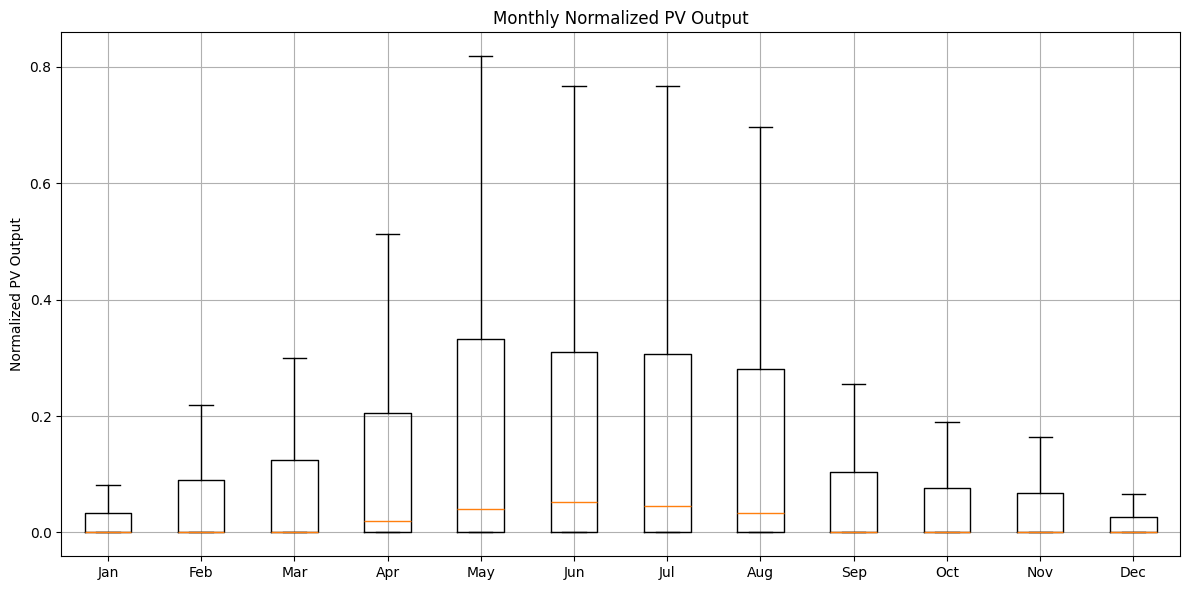

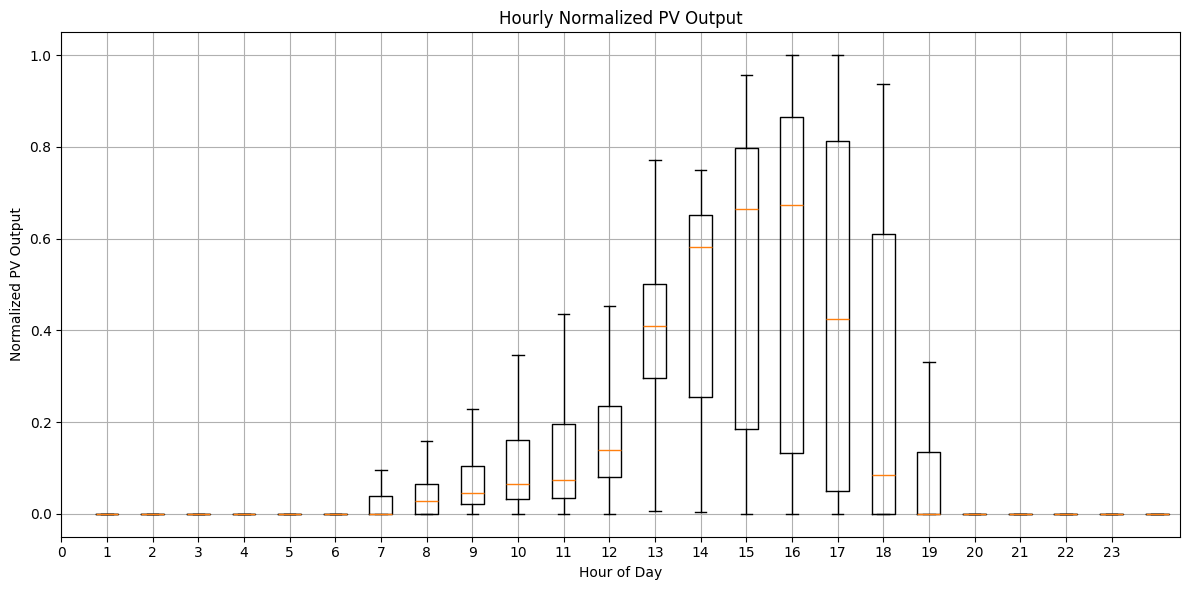

In [ ]:
merged["month"] = merged.index.month
merged["hour"] = merged.index.hour

fig, ax = plt.subplots(figsize=(12, 6))
monthly_boxes = [merged.loc[merged['month'] == m, 'pv_ac_normalized'].dropna() for m in range(1, 13)]
ax.boxplot(monthly_boxes, showfliers=False)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title("Monthly Normalized PV Output")
ax.set_ylabel("Normalized PV Output")
ax.grid(True)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
hourly_boxes = [merged.loc[merged['hour'] == h, 'pv_ac_normalized'].dropna() for h in range(24)]
ax.boxplot(hourly_boxes, showfliers=False)
ax.set_xticks(range(0, 24))
ax.set_xticklabels([str(h) for h in range(24)])
ax.set_title("Hourly Normalized PV Output")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Normalized PV Output")
ax.grid(True)
plt.tight_layout()
plt.show()
